In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
DATA_DIR = '../../raw_data'

In [17]:
# loading data
top_200_songs = pd.read_csv(f'{DATA_DIR}/beema/cleaned_data/top_200_song_consumption_cleaned.csv')
top_200_albums = pd.read_csv(f'{DATA_DIR}/beema/cleaned_data/billboard_200_cleaned.csv')

In [3]:
top_200_songs

,Rank,Song,Artist,Label Description,Label,Peak Position,Last Week Rank,Last 2 Week Rank,Weeks On Chart,Genre,Release Date,TW Total Activity,% Chg Total Activity,LW Total Activity,TW Song Sales,TW On-Demand Audio Streams,TW On-Demand Video Streams,TW Total SES (Audio + Video),week_of
0,1,Last Night,Morgan Wallen,MERCURY / BIG LOUD / REPUBLIC RECORDS,R-MR,1,1.0,1.0,21,Country,05/06/2022,194439,0.1,194227.0,7217,23894614,2163494,187222,2023.06.22
1,2,Fast Car,Luke Combs,COLUMBIA NASHVILLE,CLNV,2,2.0,4.0,13,Country,01/27/2023,142698,2.9,138742.0,9877,16905495,995505,132821,2023.06.22
2,3,Ella Baila Sola,Eslabon Armado,DEL RECORDS,DLRI,1,3.0,2.0,14,Latin,02/16/2023,127309,-8.1,138506.0,1224,16953990,2489035,126085,2023.06.22
3,4,All My Life,Lil Durk Feat. J. Cole,Alamo Records,ALAM,2,4.0,3.0,6,R&B/Hip-Hop,05/05/2023,125573,-8.1,136696.0,3402,15290571,3118359,122171,2023.06.22
4,5,Fukumean,Gunna,300 ENTERTAINME,300E,5,NaN,NaN,1,R&B/Hip-Hop,06/16/2023,113544,NaN,NaN,313,14517399,720545,113231,2023.06.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14192,196,Noid,"Tyler, The Creator",COLUMBIA,COL,2,97.0,59.0,6,R&B/Hip-Hop,10/01/2011,33384,-21.6,42558.0,51,4566864,249087,33333,2024.11.28
14193,197,Carol Of The Bells,John Williams,SONY CLASSICS,SNYC,136,NaN,NaN,8,Holiday/Seasonal,11/30/1990,33370,NaN,NaN,232,4539675,9778,33138,2024.11.28
14194,198,Save Your Tears,Weeknd,REPUBLIC RECORDS,R-RR,2,174.0,173.0,206,Pop,03/20/2020,33342,0.1,33304.0,322,4093561,813108,33020,2024.11.28
14195,199,I Can Do It With A Broken Heart,Taylor Swift,REPUBLIC RECORDS,R-RR,3,143.0,114.0,32,Pop,03/26/2024,33272,-8.6,36394.0,526,4228878,172942,32746,2024.11.28


In [ ]:
top_200_albums

In [4]:
# Ensure 'week_of' column is in datetime format
if 'week_of' in top_200_songs.columns:
    top_200_songs['week_of'] = pd.to_datetime(top_200_songs['week_of'], format='%Y.%m.%d')
else:
    raise KeyError("'week_of' column is missing from the dataset")

# Group by 'week_of' and get the most common genre for each week
most_common_genre_per_week = top_200_songs.groupby('week_of')['Genre'].agg(lambda x: x.mode()[0])

# Display the result
most_common_genre_per_week


week_of
2023-06-22    R&B/Hip-Hop
2023-06-29    R&B/Hip-Hop
2023-07-06    R&B/Hip-Hop
2023-07-13        Country
2023-07-20        Country
                 ...     
2024-10-24    R&B/Hip-Hop
2024-10-31    R&B/Hip-Hop
2024-11-07    R&B/Hip-Hop
2024-11-14    R&B/Hip-Hop
2024-11-28    R&B/Hip-Hop
Name: Genre, Length: 71, dtype: object

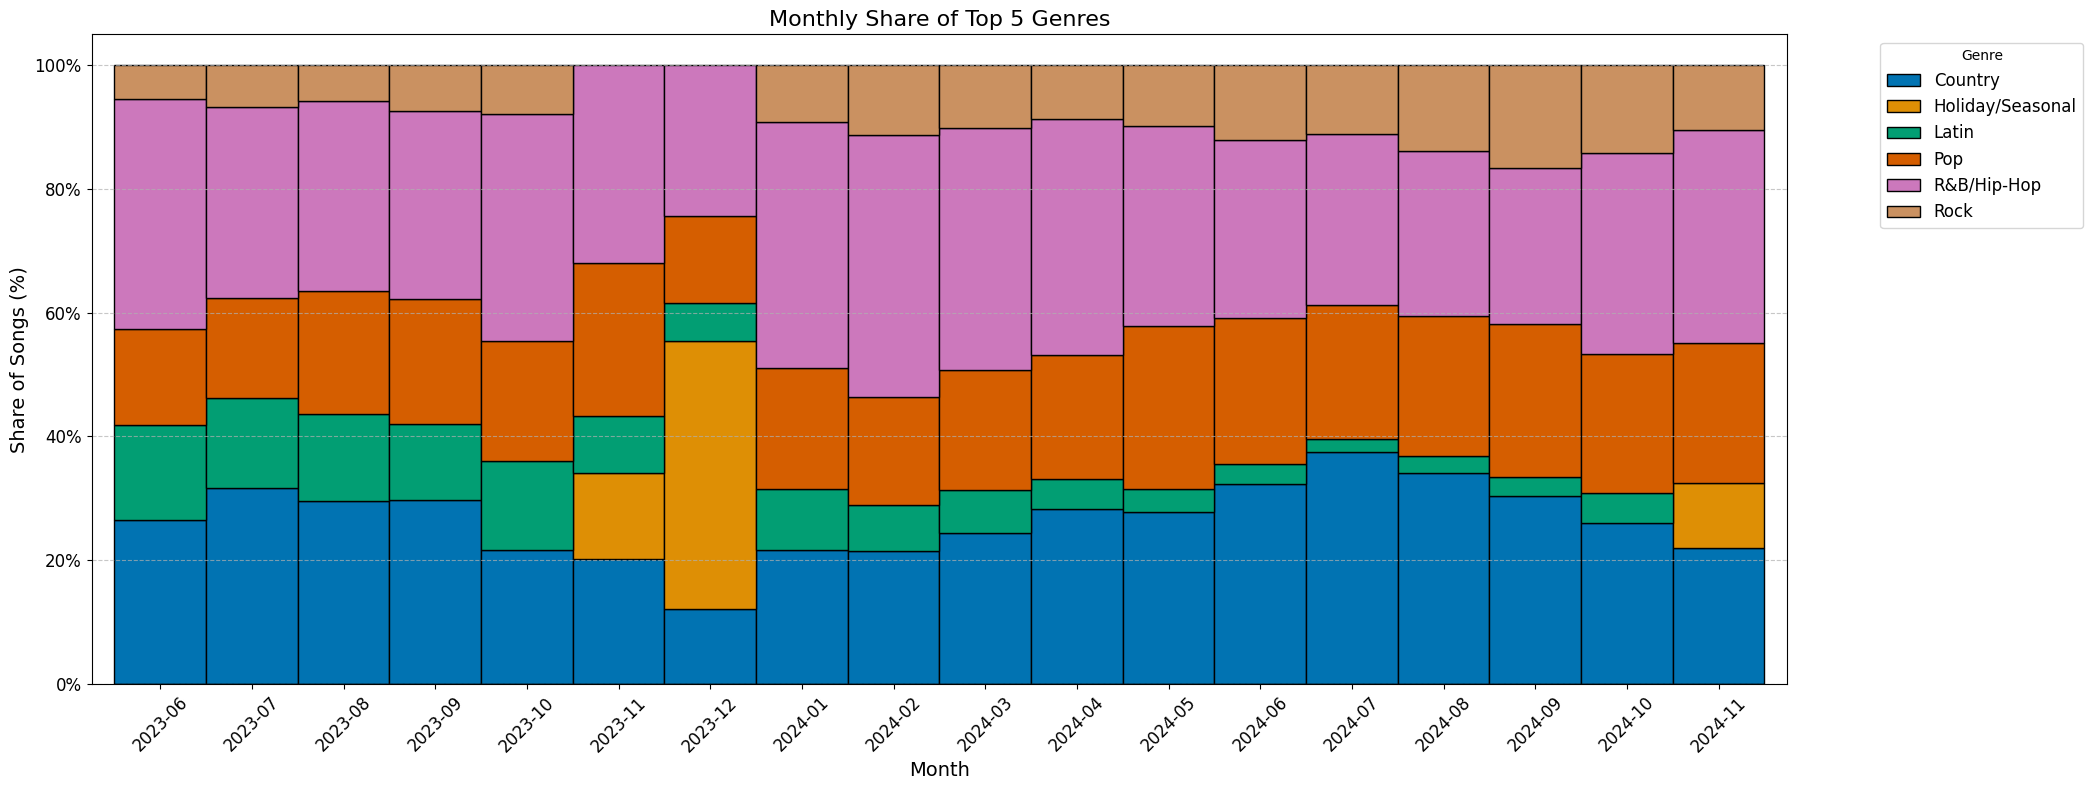

In [8]:
# Extract month from week_of and create monthly groups
top_200_songs['month'] = top_200_songs['week_of'].dt.to_period('M')

# Create pivot table with monthly aggregation
genre_counts_per_month = top_200_songs.pivot_table(index='month', 
                                                  columns='Genre', 
                                                  aggfunc='size', 
                                                  fill_value=0)

# For each month, keep only top 5 genres and set others to 0
top_5_monthly = pd.DataFrame(index=genre_counts_per_month.index, columns=genre_counts_per_month.columns)
for month in genre_counts_per_month.index:
    month_data = genre_counts_per_month.loc[month]
    
    # Get top 5 genres for this month
    top_5_genres = month_data.nlargest(5)
    
    # Create a new row with only top 5 genres
    new_row = month_data.copy()
    new_row[~new_row.index.isin(top_5_genres.index)] = 0
    top_5_monthly.loc[month] = new_row

# Convert to percentages
genre_percentages = top_5_monthly.div(top_5_monthly.sum(axis=1), axis=0) * 100

# Remove columns that are all zeros (genres that never made top 5)
genre_percentages = genre_percentages.loc[:, (genre_percentages != 0).any(axis=0)]

# Create the stacked bar chart using seaborn
plt.figure(figsize=(21, 8))
sns.set_palette("colorblind")  # Use colorblind-friendly colors
genre_percentages.plot(kind='bar', 
                      stacked=True,
                      width=1,
                      edgecolor='black',
                      ax=plt.gca())

# Customize the plot
plt.xlabel('Month', fontsize=14)
plt.ylabel('Share of Songs (%)', fontsize=14)
plt.title('Monthly Share of Top 5 Genres', fontsize=16)
plt.legend(title='Genre', 
          bbox_to_anchor=(1.05, 1), 
          loc='upper left', 
          fontsize=12)

# Format the x-tick labels to display months in a more readable format
plt.xticks(ticks=range(len(genre_percentages.index)), 
          labels=[month.strftime('%Y-%m') for month in genre_percentages.index], 
          rotation=45, 
          fontsize=12)

plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage signs to y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

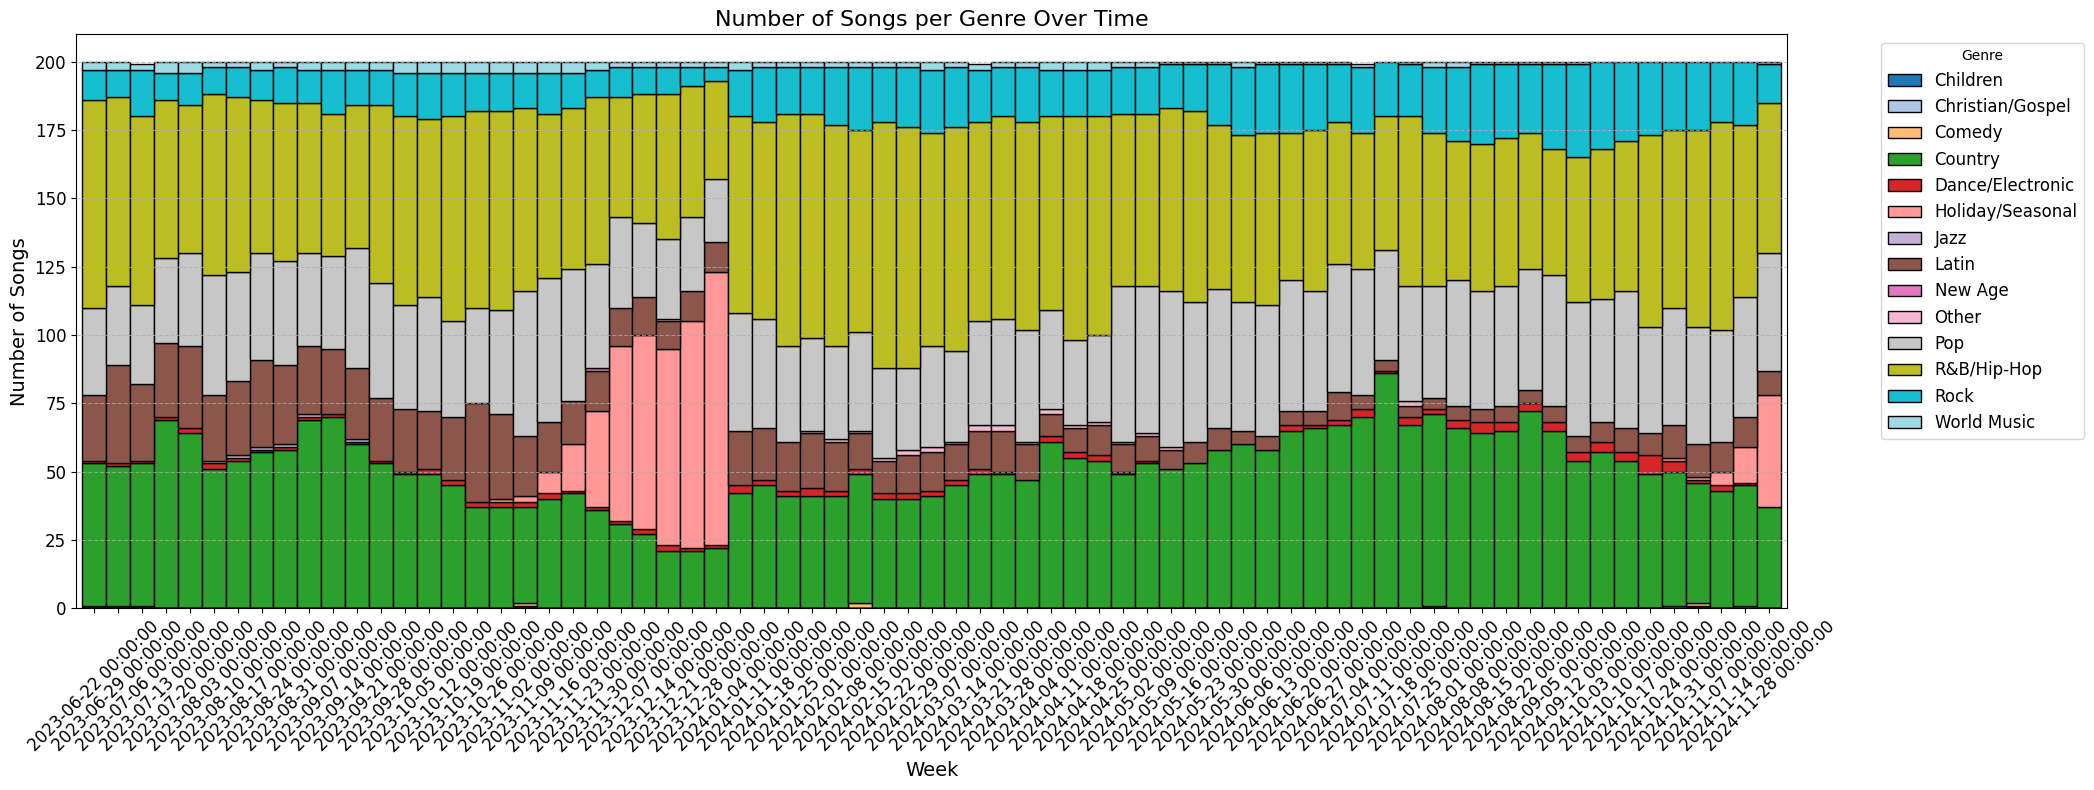

In [11]:
# Pivot the data to get the count of each genre per week
genre_counts_per_week = top_200_songs.pivot_table(index='week_of', columns='Genre', aggfunc='size', fill_value=0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(21, 8))
genre_counts_per_week.plot(kind='bar', stacked=True, colormap='tab20', width=1, edgecolor='black', ax=ax)

# Adding labels and title
ax.set_xlabel('Week', fontsize=14)
ax.set_ylabel('Number of Songs', fontsize=14)
ax.set_title('Number of Songs per Genre Over Time', fontsize=16)
ax.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


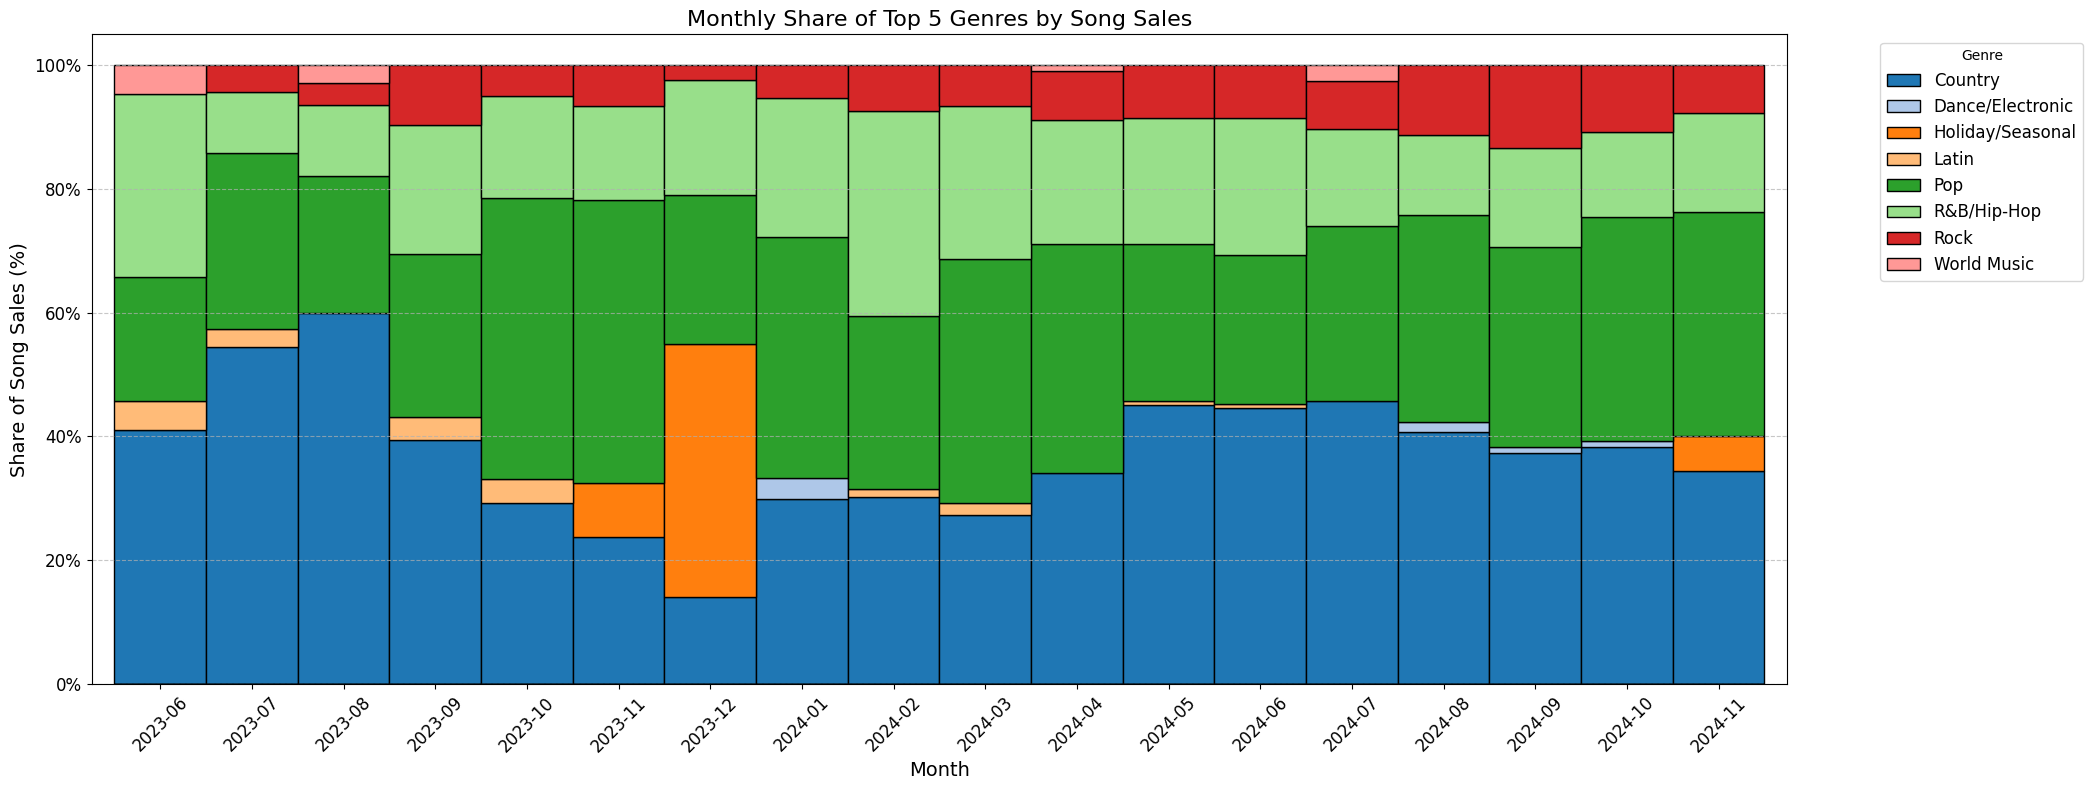

In [15]:
# Pivot the data to get the total song sales per genre per month
top_200_songs['month_of'] = top_200_songs['week_of'].dt.to_period('M')
genre_sales_per_month = top_200_songs.pivot_table(index='month_of', columns='Genre', values='TW Song Sales', aggfunc='sum', fill_value=0)

# For each month, keep only top 5 genres and set others to 0
top_5_monthly_sales = pd.DataFrame(index=genre_sales_per_month.index, columns=genre_sales_per_month.columns)
for month in genre_sales_per_month.index:
    month_data = genre_sales_per_month.loc[month]
    
    # Get top 5 genres for this month
    top_5_genres = month_data.nlargest(5)
    
    # Create a new row with only top 5 genres
    new_row = month_data.copy()
    new_row[~new_row.index.isin(top_5_genres.index)] = 0
    top_5_monthly_sales.loc[month] = new_row

# Convert to percentages
genre_sales_percentages = top_5_monthly_sales.div(top_5_monthly_sales.sum(axis=1), axis=0) * 100

# Remove columns that are all zeros (genres that never made top 5)
genre_sales_percentages = genre_sales_percentages.loc[:, (genre_sales_percentages != 0).any(axis=0)]

# Plotting the stacked bar chart
plt.figure(figsize=(21, 8))
sns.set_palette("tab20")  # Use a colormap
genre_sales_percentages.plot(kind='bar', 
                             stacked=True, 
                             width=1, 
                             edgecolor='black', 
                             ax=plt.gca())

# Adding labels and title
plt.xlabel('Month', fontsize=14)
plt.ylabel('Share of Song Sales (%)', fontsize=14)
plt.title('Monthly Share of Top 5 Genres by Song Sales', fontsize=16)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Format the x-tick labels to display months in a more readable format
plt.xticks(ticks=range(len(genre_sales_percentages.index)), 
           labels=[month.strftime('%Y-%m') for month in genre_sales_percentages.index], 
           rotation=45, 
           fontsize=12)

plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage signs to y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()
